In [1]:
import pandas as pd
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import numpy as np

Using TensorFlow backend.


In [2]:
TRAINING_SAMPLES = 15000
VALIDATION_SAMPLES = 6000
MAX_WORDS = 10000
MAX_FEATURE_LEN = 1000

In [3]:
train_data = pd.read_csv('../Data/train.csv')

nan_idx = train_data[pd.isnull(train_data.text)].index.tolist()
train_data.loc[nan_idx, 'text'] = ' '

In [4]:

tokenizer = Tokenizer(num_words=MAX_WORDS)

tokenizer.fit_on_texts(train_data.text)
sequences = tokenizer.texts_to_sequences(train_data.text)

print(f'Znaleziono {len(tokenizer.word_index)} unikatowych tokenów.')

data = pad_sequences(sequences, maxlen=MAX_FEATURE_LEN)
labels = train_data.label

print(f'Kształt tensora danych: {data.shape}')
print(f'Kształt tensora etykiet: {labels.shape}')

Znaleziono 238051 unikatowych tokenów.
Kształt tensora danych: (20800, 1000)
Kształt tensora etykiet: (20800,)


In [5]:
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]

x_train = data[:TRAINING_SAMPLES]
y_train = labels[:TRAINING_SAMPLES]
x_val = data[TRAINING_SAMPLES : TRAINING_SAMPLES + VALIDATION_SAMPLES]
y_val = labels[TRAINING_SAMPLES : TRAINING_SAMPLES + VALIDATION_SAMPLES]

In [6]:
EMBEDDING_DIM = 100
embedding_index = {}

with open('../GloVe/glove.6B.100d.txt', encoding="utf8") as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embedding_index[word] = coefs

embedding_matrix = np.zeros((MAX_WORDS, EMBEDDING_DIM))
for word, i in tokenizer.word_index.items():
    embedding_vector = embedding_index.get(word)
    if i < MAX_WORDS:
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
print('Glove załadowane!')

Glove załadowane!


In [42]:
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense, Dropout

model = Sequential()

model.add(Embedding(MAX_WORDS, EMBEDDING_DIM, input_length=MAX_FEATURE_LEN))
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False
model.add(Flatten())
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(8, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc',])

model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 1000, 100)         1000000   
_________________________________________________________________
flatten_6 (Flatten)          (None, 100000)            0         
_________________________________________________________________
dense_11 (Dense)             (None, 16)                1600016   
_________________________________________________________________
dropout_3 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_12 (Dense)             (None, 8)                 136       
_________________________________________________________________
dropout_4 (Dropout)          (None, 8)                 0         
_________________________________________________________________
dense_13 (Dense)             (None, 1)                

In [43]:
history = model.fit(x_train, y_train, epochs=20, batch_size=512, validation_data=(x_val, y_val))

Train on 15000 samples, validate on 5800 samples
Epoch 1/20
15000/15000 [==============================] - 2s 118us/step - loss: 0.9163 - acc: 0.5132 - val_loss: 0.6554 - val_acc: 0.6548
Epoch 2/20
15000/15000 [==============================] - 2s 102us/step - loss: 0.6858 - acc: 0.5849 - val_loss: 0.6230 - val_acc: 0.6672
Epoch 3/20
15000/15000 [==============================] - 2s 102us/step - loss: 0.6575 - acc: 0.5888 - val_loss: 0.6306 - val_acc: 0.6343
Epoch 4/20
15000/15000 [==============================] - 2s 102us/step - loss: 0.6418 - acc: 0.6084 - val_loss: 0.6027 - val_acc: 0.6709
Epoch 5/20
15000/15000 [==============================] - 2s 102us/step - loss: 0.6342 - acc: 0.6174 - val_loss: 0.6090 - val_acc: 0.6610
Epoch 6/20
15000/15000 [==============================] - 2s 102us/step - loss: 0.6291 - acc: 0.6250 - val_loss: 0.5876 - val_acc: 0.6866
Epoch 7/20
15000/15000 [==============================] - 2s 101us/step - loss: 0.6312 - acc: 0.6224 - val_loss: 0.6091 - v

In [50]:
model.save_weights('pre_trained_model.h5')

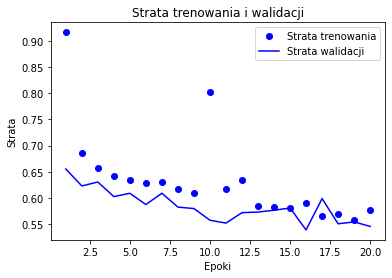

In [44]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'bo', label='Strata trenowania')
plt.plot(epochs, val_loss, 'b', label='Strata walidacji')

plt.title('Strata trenowania i walidacji')
plt.xlabel('Epoki')
plt.ylabel('Strata')
plt.legend()

plt.show()

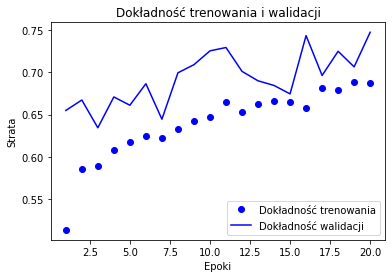

In [45]:
plt.clf()

acc = history.history['acc']
val_acc = history.history['val_acc']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, acc, 'bo', label='Dokładność trenowania')
plt.plot(epochs, val_acc, 'b', label='Dokładność walidacji')

plt.title('Dokładność trenowania i walidacji')
plt.xlabel('Epoki')
plt.ylabel('Strata')
plt.legend()

plt.show()

In [48]:
test_data = pd.read_csv('../Data/test.csv')

nan_idx = test_data[pd.isnull(test_data.text)].index.tolist()
test_data.loc[nan_idx, 'text'] = ' '

sequences = tokenizer.texts_to_sequences(test_data.text)

y_test = test_data.label

model.evaluate(x_test, y_test)

5200/5200 [==============================] - 1s 194us/step


[0.40896033947284405, 0.8946154117584229]